In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
from scipy import interpolate

# Interpolation using Radial Basis Functions

In our previous notebook we integrated the dynamics of particles in a velocity field
$$ {\frac {d\vec p}{dt}} = \vec v(x,y). $$

We assumed that the velocity function $\vec v = [u,v]$ is given everywhere. However, this is not realistic. A much more realistic case is that we have some measurements of $\vec v$ at some points $\vec x_j,\, j=1,\ldots,n$ and we need to approximate $\vec v$ at every points $\vec x$ given the data. This is the task of interpolation.

In this notebook we discuss the use of Radian Basis Functions for the interpolation of points in 2D. The method is good for the generation of smooth interpolation to data in many dimentions.



# Assumptions
We start by stating the assumptions 

1. We are given $n$ locations $\vec x_j = [x_j,y_j], j=1,\ldots,n$ 
2. We know the value of a function $f_j = f(x_j,y_j)$ 
3. The function is assumed to be smooth 

Our goal is to approximate $f(x,y)$ such that we can estimate it at an arbitrary point.

# Basic Idea

The idea behind RBF interpolation is to approximate $f(x,y)$ by a sum of smooth {\bf known functions} and
{\bf unknown coefficients}.
$$ \widehat f(x,y) = \sum_j c_j \phi_j(x,y). $$ 
Note that we use $\widehat f(x,y)$ and not $f(x,y)$ to express that the function is only as estimate of the true function and not the true function itself.

The functions $\phi_j(x,y)$ are chosen to be smooth basis functions, for example
$$ \phi_j(x,y) = \exp \left( -{\frac {(x-x_j)^2 + (y-y_j)^2}{\sigma^2}} \right). $$ 

An example for such a function is plotted below

In [ ]:
def RBFfun(x,y,xI,yI,sigma):
    phi = torch.exp(-((x-xI)**2 + (y-yI)**2)/sigma**2)
    return phi

We now plot this function 

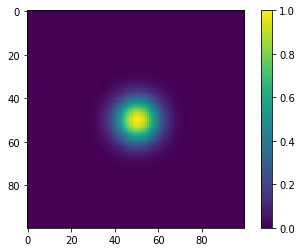

In [ ]:
X, Y = torch.meshgrid([torch.arange(-50,50), torch.arange(-50,50)])
X = 0.01*X; Y = 0.01*Y
xj = 0.0; yj = 0.0; sigma = .1
Z = RBFfun(xj,yj,X,Y,sigma)
plt.imshow(Z)
plt.colorbar()

## Class assignment: 
Play with the code, what happens to the function when $\sigma \ll 1$ and $\sigma \gg 1$

# The interpolation conditions

We can now write the interpolation conditions
$$ \widehat f(x_i,y_i) = \sum_j c_j \phi_j(x_i,y_i). $$
Or in matrix terms
$$ {\bf f} = {\bf A} {\bf c} $$

where
$$ 
{\bf f} =[f(x_1,y_1),\ldots,f(x_n,y_n)]\\
{\bf A}_{ij} = \phi_i(x_j,y_j)\\
{\bf c} =[c_1,\ldots,c_n]$$

Which means that 
$$ {\bf c} = {\bf A}^{-1} {\bf f} $$



# Coding interpolation

The code involves setting up the matrix, sometimes refers to as the Kernel, setting up the right hand side and then solving it. Then, assuming we have the coefficients we interpolate the data to the point(s) we wish.

In [ ]:
def RBFmatrix(x,y,sigma):

    n = x.shape[0]
    A = torch.zeros(n,n);
    for i in range(n):
        for j in range(n):
            A[i,j] = RBFfun(x[i],y[i],x[j],y[j],sigma);
    return A

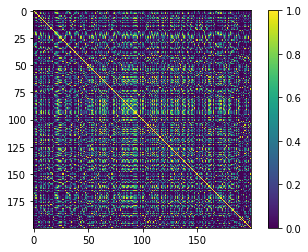

In [ ]:
# Test the matrix
X = torch.randn(200)
Y = torch.randn(200)
sigma = 1.0
A = RBFmatrix(X,Y,sigma)

plt.imshow(A); plt.colorbar()

# Using the matrix we now solve for the coefficients and interpolate

In [ ]:
def RBFinterp(x,y,f,xI,yI,sigma):

    # Compute the RBF matrix
    A = RBFmatrix(x,y,sigma);

    # Compute the coefficients
    c, LU = torch.solve(f.unsqueeze(1),A)

    # Compute the data on the new points
    nI = xI.shape[0]
    n  = x.shape[0]
    vI = torch.zeros(nI)
    for i in range(nI):
        for j in range(n):
            vi = c[j]*RBFfun(x[j],y[j],xI[i],yI[i],sigma)
            vI[i] += vi[0];
    
    return vI

# Testing the code
Assume that we measure some field (say temperature) in some 100 randon stations

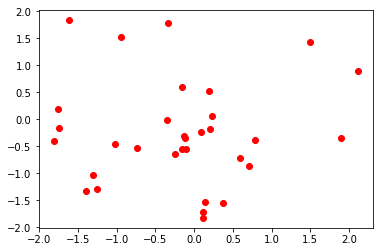

In [ ]:
# Test the code
# define some function
def fun2interp(X,Y):
    F = X*torch.exp(-(X**2+Y**2)/0.5) - Y*torch.exp(-((X-0.5)**2+(Y-0.5)**2))
    return F


x = torch.randn(32)
y = torch.randn(32)

Tobs = fun2interp(x,y)

plt.plot(x,y,'or')


## And we want to interpolate it to a regular grid

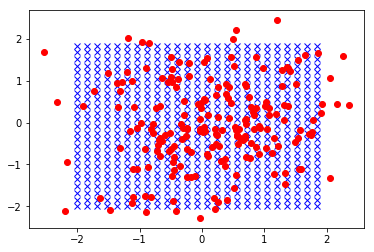

In [ ]:
Xint, Yint = torch.meshgrid([torch.arange(-50,50,4), torch.arange(-50,50,4)])
Xint = 0.04*Xint; Yint = 0.04*Yint

plt.plot(Xint,Yint,'xb',X,Y,'or');

## We compute the RBF interpolation first

In [ ]:
sigma = 5e-1
TiRBF = RBFinterp(x,y,Tobs,Xint.view(-1),Yint.view(-1),sigma);

In [ ]:
TiRBF = TiRBF.view(Xint.shape[0],Xint.shape[1])

## We now can plot the interpolated function

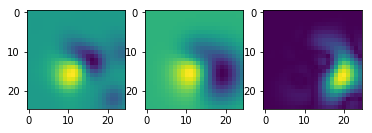

In [ ]:
Ttrue = fun2interp(Xint,Yint)
plt.subplot(1,3,1)
plt.imshow(TiRBF);
plt.subplot(1,3,2)
plt.imshow(Ttrue); 
plt.subplot(1,3,3)
plt.imshow(torch.abs(Ttrue-TiRBF)); 

# Homework assignment

We now use cross validation to choose $\sigma$.
To this end we need to have two sets of points. Training points $(x_T,y_T)$ and validating points $(x_V, y_V)$.
The points shoud be chosen from the same distributions, as below

In [ ]:
X = torch.randn(200)
Y = torch.randn(200)
F = fun2interp(X,Y)

k = 150
xT = X[:k]; yT = Y[:k]  # training
xV = X[k:]; yV = Y[k:]  # validating

fT = F[:k]
fV = F[k:]


In [ ]:
sigma = 0.01
## Your code here

# Use the point xT, yT to evaluate the function at xV and yV
# fV_est = ...

# compare the error with the true function
# err = ...


In [ ]:
# Do the same as the above but loop over values of sigma
sigma = 1e-3
for i in range(16):
    sigma *= 2
    # compute interpolation and error and record sigma and the error
    # sig[i] = sigma
    # r[i]   = err
    
 # Print the optimal value of sigma